In [1]:
import os
import h5py
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from DataMaker import *
from sys import stdout
from datetime import datetime

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Cropping2D, ZeroPadding2D
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import Input, Flatten, Dense, Reshape
import tensorflow_probability as tfp
from tensorflow_probability import layers as tfpl
from tensorflow_probability import distributions as tfd
from tensorflow.nn import leaky_relu
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau

In [3]:
gpus = tf.config.list_physical_devices('GPU');
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit = 20000)]);
        logical_gpus = tf.config.experimental.list_logical_devices('GPU');
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


2022-11-10 22:22:56.678500: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-10 22:22:56.697636: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-10 22:22:56.698729: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-10 22:22:56.701095: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [4]:
LATENT_DIM = 128
BASE_DEPTH = 8
IMAGE_SHAPE = (5, 127, 127)
EPOCHS = 200
CHECKPOINTS_TO_SAVE = 4
KL_WEIGHT = 1e-6
# Good value: between 1e-6 and 1e-7

In [5]:
now = datetime.now()

DATASET_NAME = "HSC_v6_small"
MODEL_TYPE = "VAE"
MODEL_VERSION = "v1.0." + now.strftime("%Y%m%d_%H_%M_%S")

MODEL_DESCRIPTION = "Restricting to z less than 0.1"

model_id = '_'.join([DATASET_NAME, MODEL_TYPE, MODEL_VERSION])
model_path = os.path.join('/models', model_id, 'model')
checkpoints_path = os.path.join('/models', model_id, 'checkpoints')
logs_path = os.path.join('/logs', model_id)
predictions_path = os.path.join('/predictions', model_id)
weights_path = model_path + '/weights.h5'

os.makedirs(model_path, exist_ok = True)
os.makedirs(checkpoints_path, exist_ok = True)
os.makedirs(logs_path, exist_ok = True)
os.makedirs(predictions_path, exist_ok = True)

with open("/models/README.md", "a") as myfile:
    myfile.write("\n" + MODEL_TYPE + " " + MODEL_VERSION + ": " + MODEL_DESCRIPTION + " - B. Li")

In [39]:
hf_train = h5py.File('/data/HSC/HSC_v6/step2A/127x127/5x127x127_training_zmax0.1_small.hdf5', 'r')
hf_test = h5py.File('/data/HSC/HSC_v6/step2A/127x127/5x127x127_testing_zmax0.1_small.hdf5', 'r')
hf_validation = h5py.File('/data/HSC/HSC_v6/step2A/127x127/5x127x127_validation_zmax0.1_small.hdf5', 'r')
x_train = np.asarray(hf_train['image'][0:])
x_test = np.asarray(hf_test['image'][0:])
x_validation = np.asarray(hf_validation['image'][0:])
max_value = 4.16
x_train = np.true_divide(x_train, max_value)
x_test = np.true_divide(x_test, max_value)
x_validation = np.true_divide(x_validation, max_value)
y_train = np.asarray(hf_train['specz_redshift'][0:])[..., None]
y_test = np.asarray(hf_test['specz_redshift'][0:])[..., None]
y_validation = np.asarray(hf_validation['specz_redshift'][0:])[..., None]
# object_id_train = np.asarray(hf_train['object_id'][0:])
# object_id = np.asarray(hf_test['object_id'][0:])
# object_id_validation = np.asarray(hf_validation['object_id'][0:])
hf_train.close()
hf_test.close()
hf_validation.close()

In [7]:
# plt.hist(y_train)
# plt.show()

In [8]:
# i = len(x_train) - 1
# while i >= 0:
#     if y_train[i]>=0.1:
#         x_train = np.delete(x_train, i)
#         y_train = np.delete(y_train, i)
#     i -= 1

In [9]:
prior = tfd.Independent(tfd.Normal(loc=tf.zeros(LATENT_DIM), scale = 0.1), reinterpreted_batch_ndims=1)

class VAE(Model):
    def __init__(self):
        super(VAE, self).__init__()
        
        images = Input(shape=IMAGE_SHAPE)
        x = Conv2D(BASE_DEPTH, 3, strides=1, activation=leaky_relu,
                   padding='same', data_format='channels_first')(images)
        x = Conv2D(BASE_DEPTH, 3, strides=2, activation=leaky_relu,
                   padding='same', data_format='channels_first')(x)
        x = Conv2D(BASE_DEPTH, 3, strides=1, activation=leaky_relu,
                   padding='same', data_format='channels_first')(x)
        x = Conv2D(BASE_DEPTH, 3, strides=2, activation=leaky_relu,
                   padding='same', data_format='channels_first')(x)
        x = Conv2D(8, 3, strides=1, activation=leaky_relu,
                   padding='same', data_format='channels_first')(x)
        x = Flatten()(x)
        x = Dense(tfpl.MultivariateNormalTriL.params_size(LATENT_DIM), activation=None)(x)
        z = tfpl.MultivariateNormalTriL(LATENT_DIM,
                  activity_regularizer=tfpl.KLDivergenceRegularizer(prior, weight=KL_WEIGHT))(x)
        self.encoder = Model(images, z, name='encoder')

        latents = Input(shape=LATENT_DIM)
        x = Dense(4*LATENT_DIM*32*32, activation=None)(latents)
        x = Reshape((4*LATENT_DIM,32,32))(x)
        x = Conv2DTranspose(8, 3, strides=1, activation=leaky_relu,
                            padding='same', data_format='channels_first')(x)
        x = Conv2DTranspose(BASE_DEPTH, 3, strides=1, activation=leaky_relu,
                            padding='same', data_format='channels_first')(x)
        x = Conv2DTranspose(BASE_DEPTH, 3, strides=2, activation=leaky_relu,
                            padding='same', data_format='channels_first')(x)
        x = Conv2DTranspose(BASE_DEPTH, 3, strides=1, activation=leaky_relu,
                            padding='same', data_format='channels_first')(x)
        x = Conv2DTranspose(BASE_DEPTH, 3, strides=2, activation=leaky_relu,
                            padding='same', data_format='channels_first')(x)
        x = Conv2DTranspose(BASE_DEPTH, 3, strides=1, activation=leaky_relu,
                            padding='same', data_format='channels_first')(x)
        x = Conv2D(IMAGE_SHAPE[0], 3, strides=1, activation=None, 
                   padding='same', data_format='channels_first')(x)
        outputs = Cropping2D(cropping=((0,1),(0,1)), data_format='channels_first')(x)
        self.decoder = Model(latents, outputs, name='decoder')

    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def summary(self):
        print(self.encoder.summary())
        print(self.decoder.summary())

In [10]:
model = VAE()
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5, 127, 127)]     0         
                                                                 
 conv2d (Conv2D)             (None, 8, 127, 127)       368       
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 64, 64)         584       
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 64, 64)         584       
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 32, 32)         584       
                                                                 
 conv2d_4 (Conv2D)           (None, 8, 32, 32)         584       
                                                                 
 flatten (Flatten)           (None, 8192)              0   

In [11]:
logs_callback = TensorBoard(log_dir = logs_path)

weights_callback = ModelCheckpoint(filepath = os.path.join(checkpoints_path, 'weights_epoch{epoch}.hdf5'), save_freq = int(EPOCHS/CHECKPOINTS_TO_SAVE), save_weights_only = True)

LR_callback = ReduceLROnPlateau()

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logs_path, histogram_freq = 1)

In [12]:
history = model.fit(x = x_train, y = x_train, epochs = EPOCHS, callbacks=[logs_callback, weights_callback, LR_callback, tensorboard_callback], validation_data = (x_validation, x_validation), verbose = 1)

Epoch 1/200


2022-11-10 22:25:24.539281: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8201
2022-11-10 22:28:09.731322: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-10 22:28:10.341037: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


313/313 [==============================] - ETA: 0s - loss: 0.2736

2022-11-10 22:30:33.588661: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 16483614720 exceeds 10% of free system memory.
2022-11-10 22:30:35.843469: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 16106127360 exceeds 10% of free system memory.


313/313 [==============================] - 437s 90ms/step - loss: 0.2736 - val_loss: 0.1814 - lr: 0.0010
Epoch 2/200
311/313 [============================>.] - ETA: 0s - loss: 0.1826

2022-11-10 22:30:59.842024: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 16483614720 exceeds 10% of free system memory.
2022-11-10 22:31:02.104351: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 16106127360 exceeds 10% of free system memory.


313/313 [==============================] - 26s 84ms/step - loss: 0.1820 - val_loss: 0.1460 - lr: 0.0010
Epoch 3/200
313/313 [==============================] - ETA: 0s - loss: 0.1565

2022-11-10 22:31:27.392998: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 16483614720 exceeds 10% of free system memory.


313/313 [==============================] - 28s 88ms/step - loss: 0.1565 - val_loss: 0.1312 - lr: 0.0010
Epoch 4/200
313/313 [==============================] - 33s 105ms/step - loss: 0.1446 - val_loss: 0.1243 - lr: 0.0010
Epoch 5/200
313/313 [==============================] - 29s 94ms/step - loss: 0.1401 - val_loss: 0.1394 - lr: 0.0010
Epoch 6/200
313/313 [==============================] - 31s 98ms/step - loss: 0.1375 - val_loss: 0.1266 - lr: 0.0010
Epoch 7/200
313/313 [==============================] - 30s 97ms/step - loss: 0.1309 - val_loss: 0.1181 - lr: 0.0010
Epoch 8/200
313/313 [==============================] - 34s 110ms/step - loss: 0.1339 - val_loss: 0.1189 - lr: 0.0010
Epoch 9/200
313/313 [==============================] - 31s 99ms/step - loss: 0.1304 - val_loss: 0.1156 - lr: 0.0010
Epoch 10/200
313/313 [==============================] - 31s 98ms/step - loss: 0.1318 - val_loss: 0.1128 - lr: 0.0010
Epoch 11/200
313/313 [==============================] - 31s 101ms/step - loss: 0.

Epoch 73/200
313/313 [==============================] - 26s 85ms/step - loss: 0.0626 - val_loss: 0.0818 - lr: 1.0000e-04
Epoch 74/200
313/313 [==============================] - 29s 91ms/step - loss: 0.0620 - val_loss: 0.0788 - lr: 1.0000e-04
Epoch 75/200
313/313 [==============================] - 26s 84ms/step - loss: 0.0612 - val_loss: 0.0800 - lr: 1.0000e-04
Epoch 76/200
313/313 [==============================] - 26s 83ms/step - loss: 0.0598 - val_loss: 0.0794 - lr: 1.0000e-04
Epoch 77/200
313/313 [==============================] - 29s 92ms/step - loss: 0.0589 - val_loss: 0.0791 - lr: 1.0000e-04
Epoch 78/200
313/313 [==============================] - 26s 84ms/step - loss: 0.0589 - val_loss: 0.0787 - lr: 1.0000e-04
Epoch 79/200
313/313 [==============================] - 26s 84ms/step - loss: 0.0595 - val_loss: 0.0772 - lr: 1.0000e-04
Epoch 80/200
313/313 [==============================] - 26s 84ms/step - loss: 0.0595 - val_loss: 0.0790 - lr: 1.0000e-04
Epoch 81/200
313/313 [==========

In [13]:
model.save_weights(weights_path)

In [14]:
model.load_weights(weights_path)

In [15]:
def save_preds(dataset = 'train', num_to_save = None):
    if dataset == 'train':
        datagen = x_train
    elif dataset == 'val':
        datagen = x_validation
    else:
        dataset = 'test'
        datagen = x_test
    preds_path = os.path.join(predictions_path, dataset + "_preds.hdf5")
    print("Saving predictions for", dataset, "dataset in", preds_path)
    
    if num_to_save is None:
        size = len(datagen)
    else:
        size = num_to_save

    with h5py.File(preds_path, 'w') as f:
        f.create_dataset('true', (size, ) + IMAGE_SHAPE)
        f.create_dataset('pred', (size, ) + IMAGE_SHAPE)
        f.create_dataset('loss', (size, ))
        for i in range(size):
            x = datagen[i]
            f['true'][i] = x
            f['pred'][i] = model(np.array([x]))
            f['loss'][i] = model.evaluate(np.array([x]), np.array([x]), verbose = 0)
            stdout.write("\rSaved %d samples of " % (i + 1) + str(size))
            stdout.flush()
            i += 1

In [16]:
save_preds('train')

Saving predictions for train dataset in /predictions/HSC_v6_small_VAE_v1.0.20221110_22_22_57/train_preds.hdf5
Saved 10000 samples of 10000

In [17]:
save_preds('val')

Saving predictions for val dataset in /predictions/HSC_v6_small_VAE_v1.0.20221110_22_22_57/val_preds.hdf5
Saved 2000 samples of 2000

In [18]:
save_preds('test')

Saving predictions for test dataset in /predictions/HSC_v6_small_VAE_v1.0.20221110_22_22_57/test_preds.hdf5
Saved 2000 samples of 2000

In [26]:
def scatter_bands_max(num_to_show = 10, index = 0):
    fig, axes = plt.subplots(nrows = int(num_to_show/5), ncols = 5, figsize = (20, int(num_to_show)))
    for i in range(index, index + num_to_show):
        x_array = np.arange(5)
        true_array = np.array([])
        pred_array = np.array([])
        for j in range(0, 5):
            true_array = np.append(true_array, np.amax(np.array([x_test[i]])[0][j]))
            pred_array = np.append(pred_array, np.amax(model(np.array([x_test[i]]))[0][j]))
        axes[int((i - index)/5)][int((i - index)%5)].scatter(x_array, true_array, c = 'blue', label = 'True')
        axes[int((i - index)/5)][int((i - index)%5)].scatter(x_array, pred_array, c = 'red', label = 'Predicted')
        axes[int((i - index)/5)][int((i - index)%5)].set_xlabel("Bands")
        axes[int((i - index)/5)][int((i - index)%5)].set_ylabel("Maximum normalized pixel value")
        axes[int((i - index)/5)][int((i - index)%5)].legend()
        
def scatter_bands_center(num_to_show = 10, index = 0):
    fig, axes = plt.subplots(nrows = int(num_to_show/5), ncols = 5, figsize = (20, int(num_to_show)))
    for i in range(index, index + num_to_show):
        x_array = np.arange(5)
        true_array = np.array([])
        pred_array = np.array([])
        for j in range(0, 5):
            true_array = np.append(true_array, np.array([x_test[i]])[0][j][63][63])
            pred_array = np.append(pred_array, model(np.array([x_test[i]]))[0][j][63][63])
        axes[int((i - index)/5)][int((i - index)%5)].scatter(x_array, true_array, c = 'blue', label = 'True')
        axes[int((i - index)/5)][int((i - index)%5)].scatter(x_array, pred_array, c = 'red', label = 'Predicted')
        axes[int((i - index)/5)][int((i - index)%5)].set_xlabel("Bands")
        axes[int((i - index)/5)][int((i - index)%5)].set_ylabel("Central pixel value")
        axes[int((i - index)/5)][int((i - index)%5)].legend()

def scatter_bands_percentile(percentile = 90, num_to_show = 10, index = 0):
    fig, axes = plt.subplots(nrows = int(num_to_show/5), ncols = 5, figsize = (20, int(num_to_show)))
    for i in range(index, index + num_to_show):
        x_array = np.arange(5)
        true_array = np.array([])
        pred_array = np.array([])
        for j in range(0, 5):
            true_90 = np.percentile(np.array([x_test[i]])[0][j].flatten(), percentile)
            pred_90 = np.percentile(np.asarray(model(np.array([x_test[i]]))[0][j]).flatten(), percentile)
            true_array = np.append(true_array, true_90)
            pred_array = np.append(pred_array, pred_90)
        axes[int((i - index)/5)][int((i - index)%5)].scatter(x_array, true_array, c = 'blue', label = 'True')
        axes[int((i - index)/5)][int((i - index)%5)].scatter(x_array, pred_array, c = 'red', label = 'Predicted')
        axes[int((i - index)/5)][int((i - index)%5)].set_xlabel('Bands')
        axes[int((i - index)/5)][int((i - index)%5)].set_ylabel(f'{percentile}th percentile normalized pixel value')
        axes[int((i - index)/5)][int((i - index)%5)].legend()

def scatter_bands_mean(num_to_show = 10, index = 0):
    fig, axes = plt.subplots(nrows = int(num_to_show/5), ncols = 5, figsize = (20, int(num_to_show)))
    for i in range(index, index + num_to_show):
        x_array = np.arange(5)
        true_array = np.array([])
        pred_array = np.array([])
        for j in range(0, 5):
            true_mean = np.mean(np.array([x_test[i]])[0][j].flatten())
            pred_mean = np.mean(np.asarray(model(np.array([x_test[i]]))[0][j]).flatten())
            true_array = np.append(true_array, true_mean)
            pred_array = np.append(pred_array, pred_mean)
        axes[int((i - index)/5)][int((i - index)%5)].scatter(x_array, true_array, c = 'blue', label = 'True')
        axes[int((i - index)/5)][int((i - index)%5)].scatter(x_array, pred_array, c = 'red', label = 'Predicted')
        axes[int((i - index)/5)][int((i - index)%5)].set_xlabel('Bands')
        axes[int((i - index)/5)][int((i - index)%5)].set_ylabel('Mean normalized pixel value')
        axes[int((i - index)/5)][int((i - index)%5)].legend()

def display_histograms(num_to_show = 2, index = 0):
    fig, axes = plt.subplots(nrows = num_to_show, ncols = 5, figsize = (20, int(num_to_show)))
    for i in range(index, index + num_to_show):
        x_array = np.arange(5)
        for j in range(0, 5):
            true_arr = sorted(np.array([x_test[i]])[0][j].flatten())
            pred_arr = sorted(np.asarray(model(np.array([x_test[i]]))[0][j]).flatten())
            true_arr = true_arr[0:int(len(true_arr)*.99)]
            pred_arr = pred_arr[0:int(len(pred_arr)*.99)]
            axes[i][j].hist(true_arr, 100, color = 'blue', label = 'True', alpha=0.5)
            axes[i][j].hist(pred_arr, 100, color = 'red', label = 'Predicted', alpha=0.5)
            axes[i][j].set_xlabel("Pixel Values")
            axes[i][j].set_ylabel("Count")
            axes[i][j].legend()
    fig.suptitle('Histograms of Predicted vs. True Image, Horizontal are Bands')
    
def display_5_bands(index):
    fig, axes = plt.subplots(nrows = 2, ncols = 5, figsize = (20, 10))
    for i in range(0, 5):
        axes[0][i].imshow(np.array([x_test[index]])[0][i])
        max_pixel_true = round(np.amax(np.array([x_test[index]])[0][i]), 2)
        axes[0][i].set_title(f'True band {i} max = ' + str(max_pixel_true))
        pred = model(np.array([x_test[index]]))[0][i]
        axes[1][i].imshow(pred)
        max_pixel_pred = round(np.amax(pred), 2)
        axes[1][i].set_title(f'Pred band {i} max = ' + str(max_pixel_pred))

In [20]:
# scatter_bands_max()

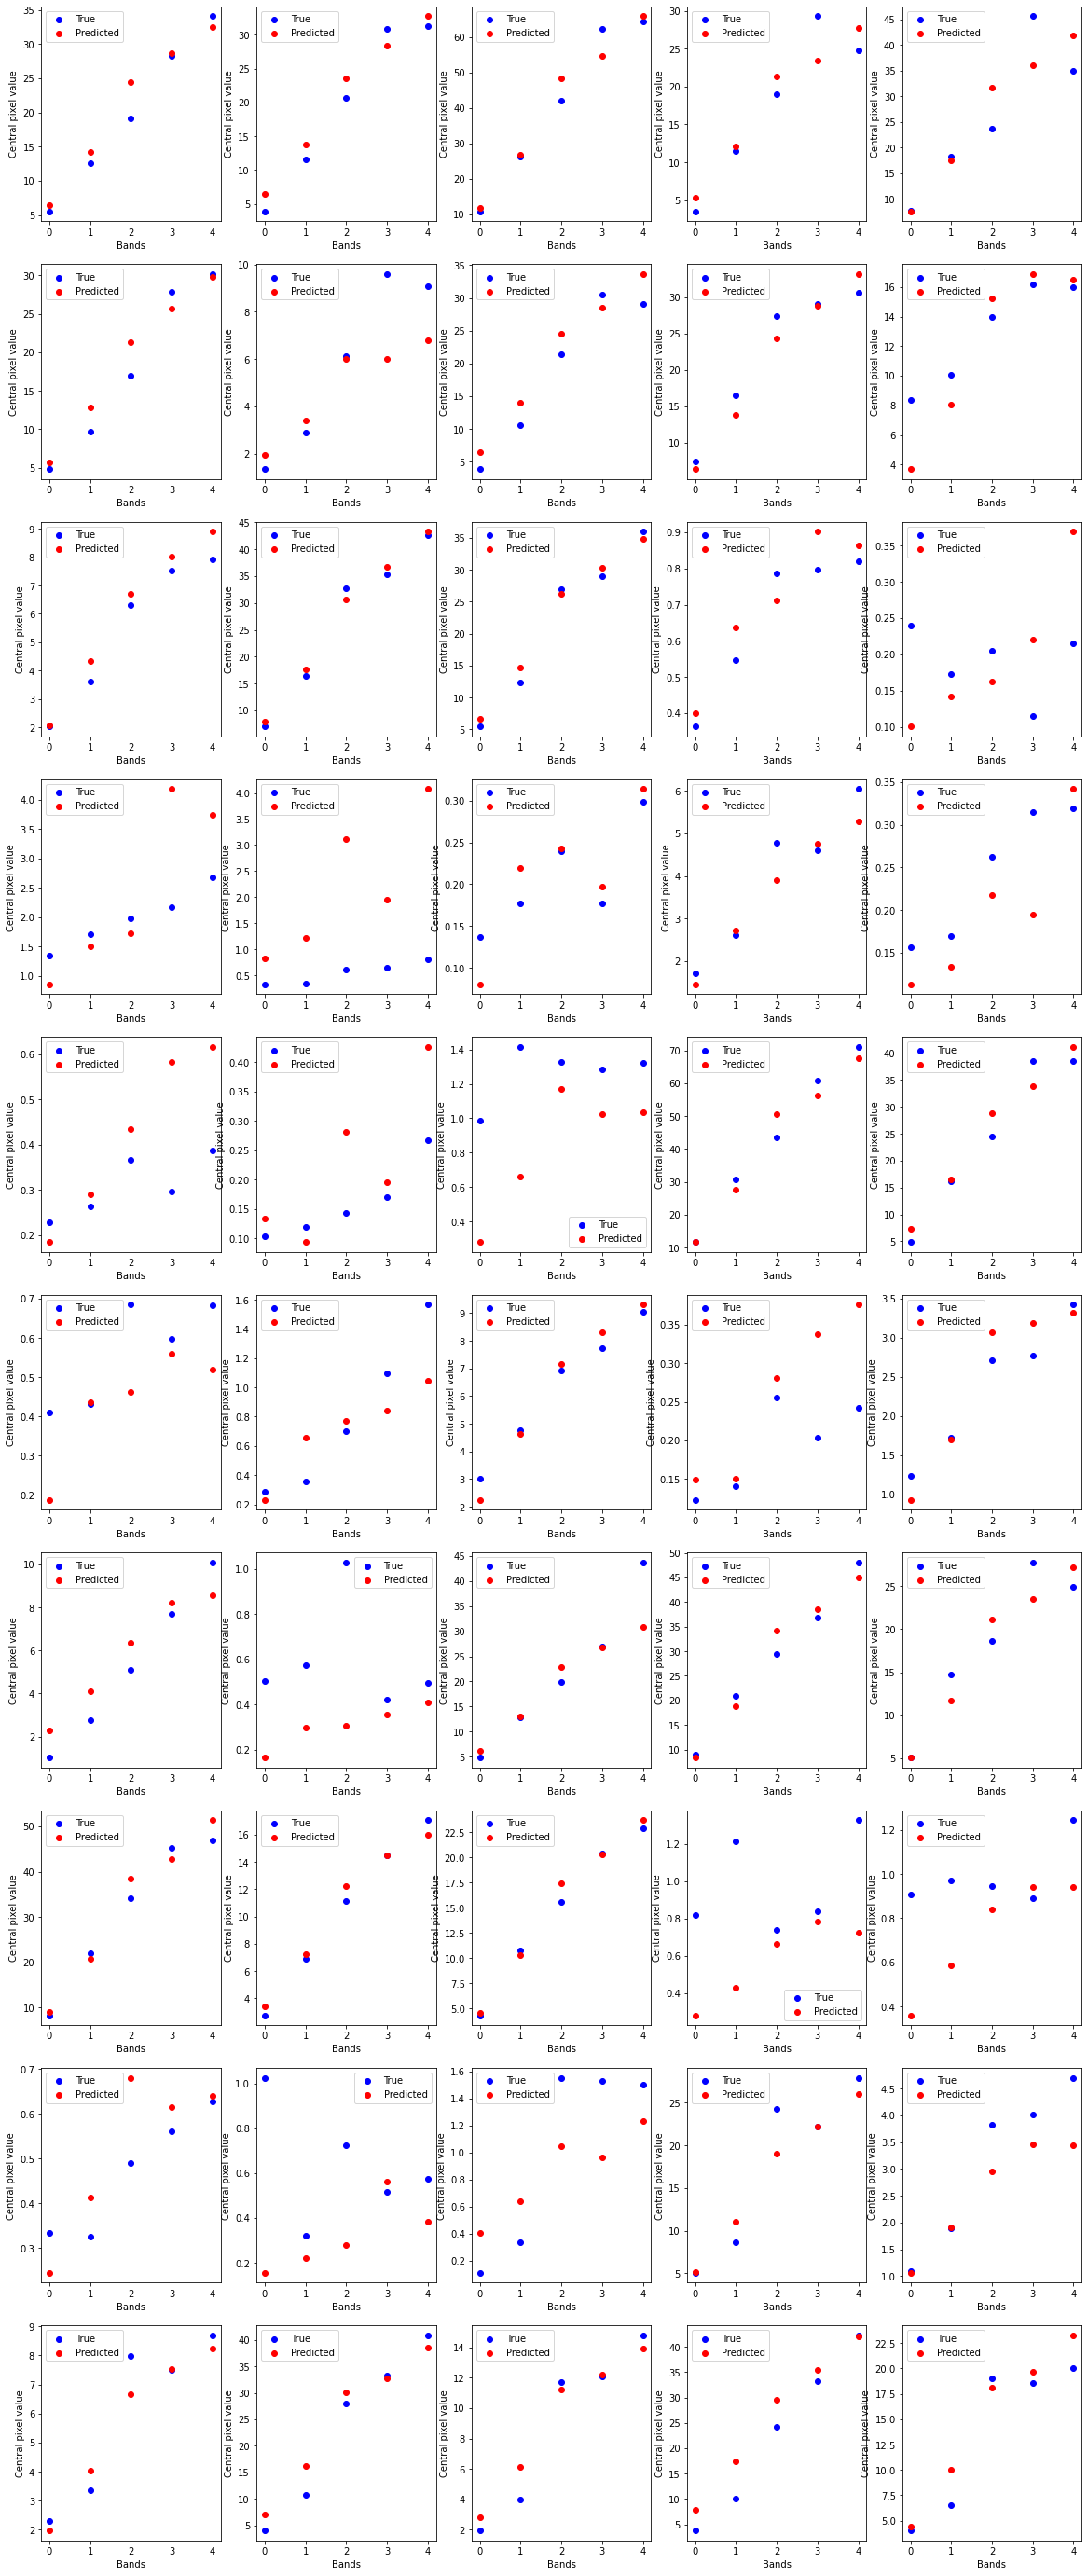

In [21]:
scatter_bands_center(50)

In [22]:
# scatter_bands_mean(10, 0)

In [23]:
# scatter_bands_percentile()

In [24]:
# display_histograms()

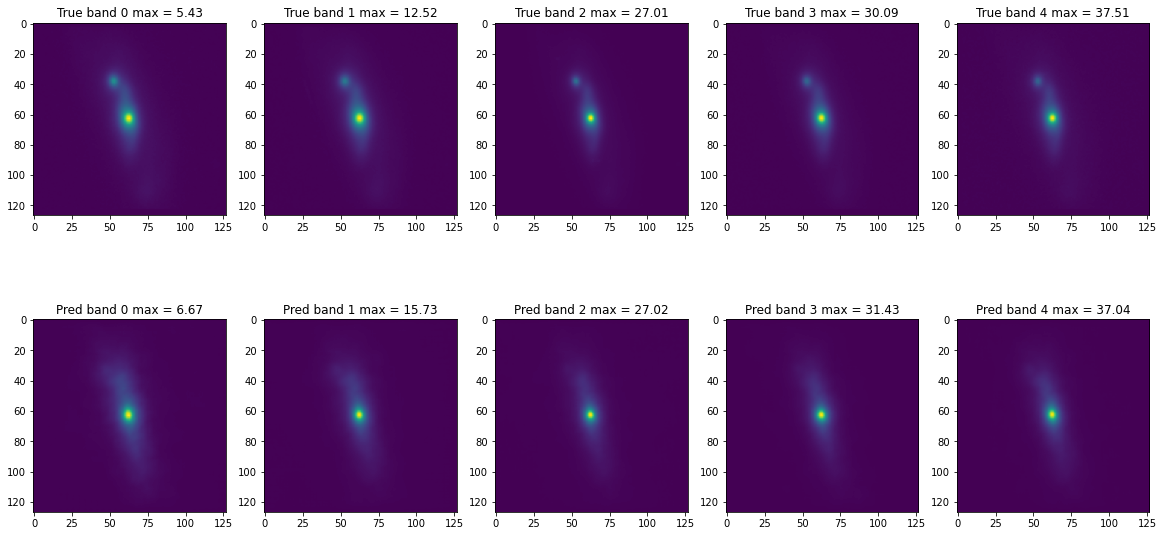

In [37]:
display_5_bands(12)

In [28]:
def generate_example_galaxies(num_to_generate = 10):
    z = prior.sample(num_to_generate)
    xhat = model.decoder(z)
    fig, axes = plt.subplots(nrows = num_to_generate, ncols = 5, figsize = (4 * 5, 4 * num_to_generate))
    for i in range(num_to_generate):
        for j in range(0,5):
            axes[i][j].imshow(xhat[i][j])
            axes[i][j].set_title(f'Generated image {i} band {j}')

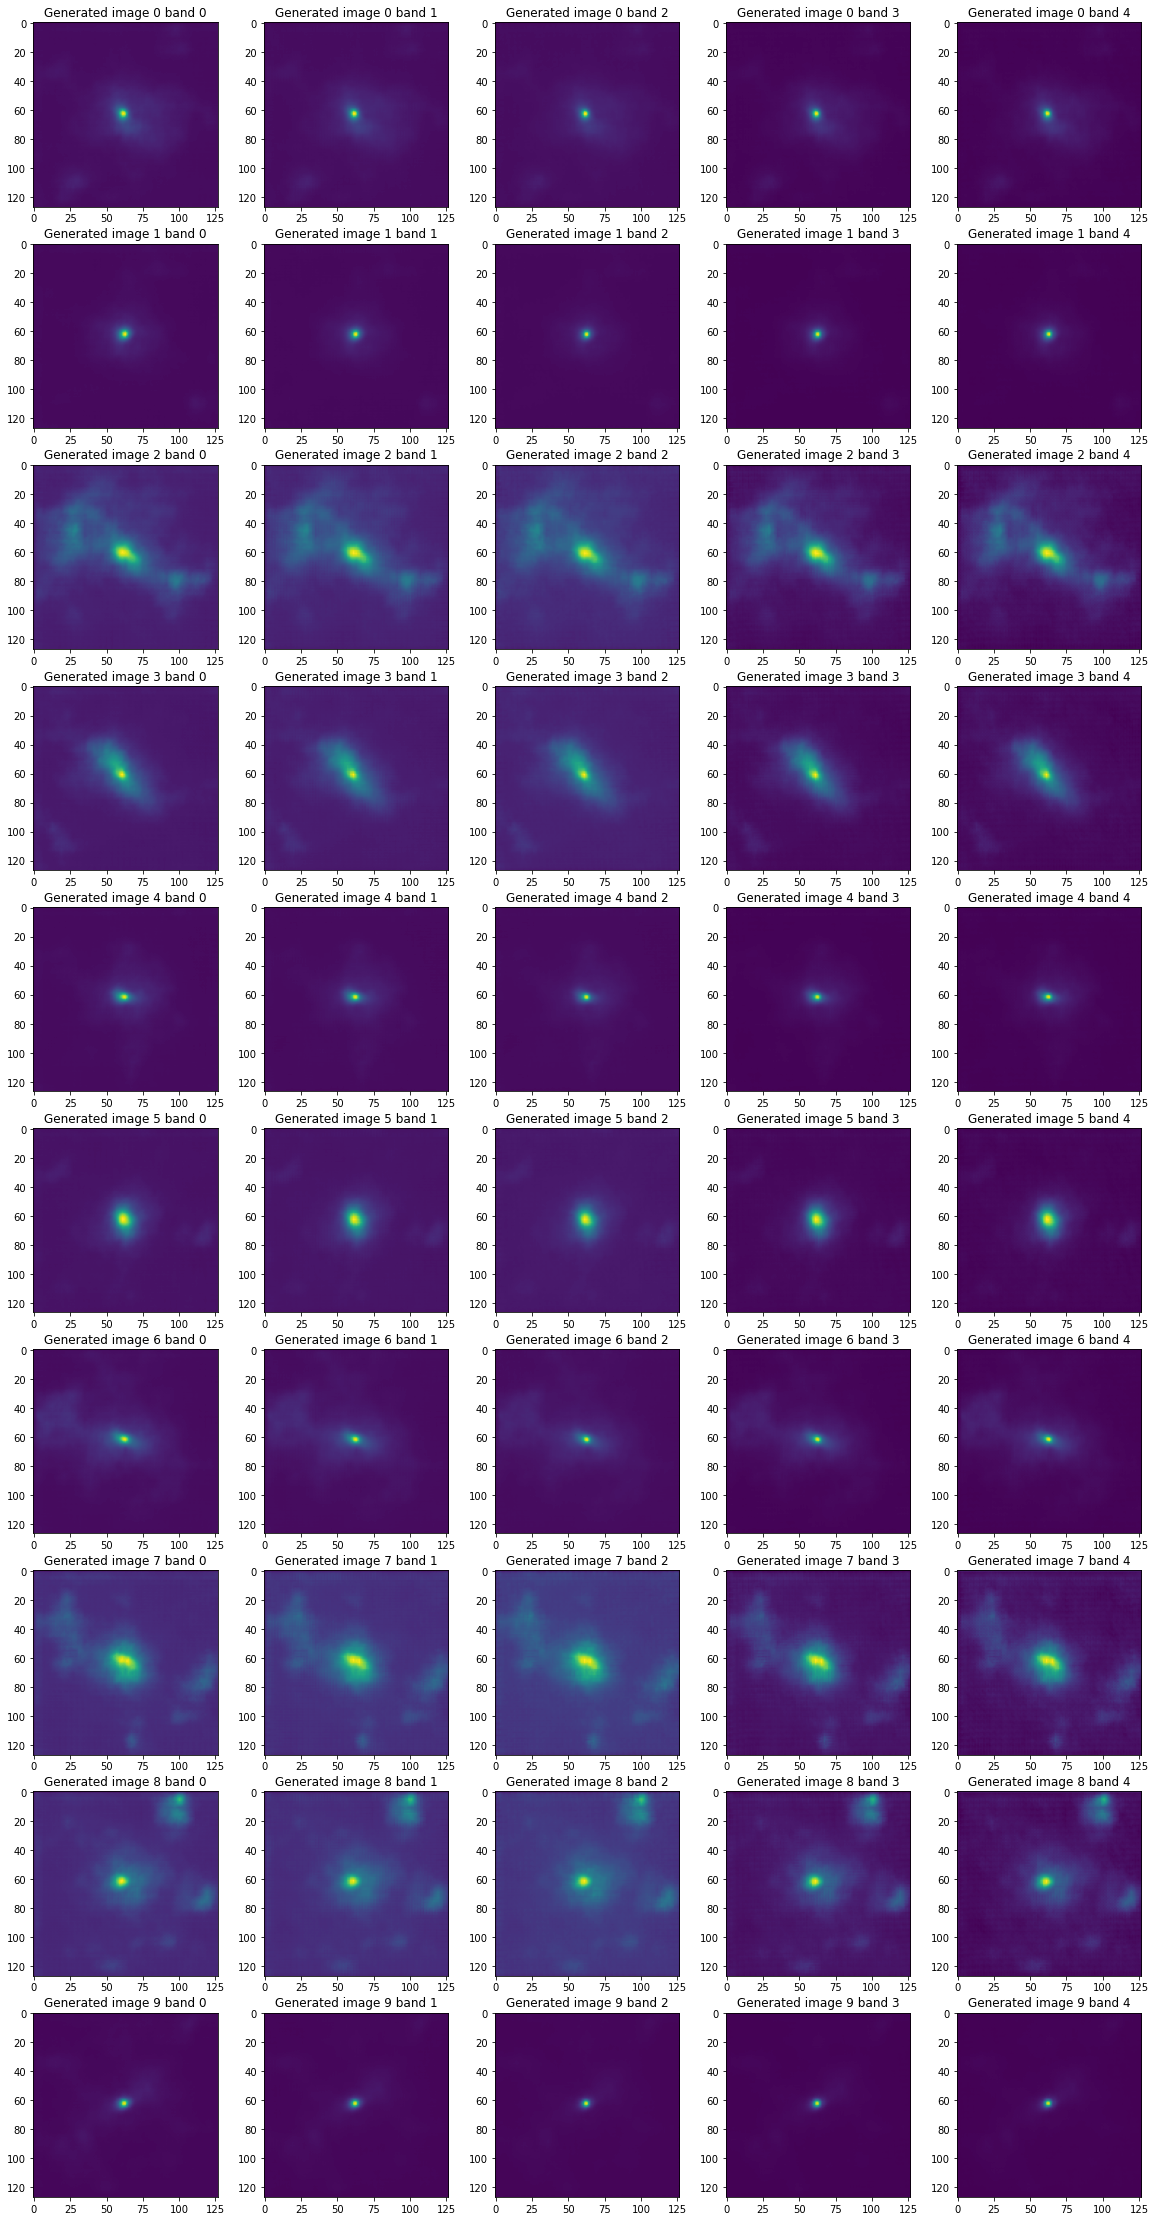

In [38]:
generate_example_galaxies(10)

In [ ]:
# END